#  Pendulum-v1 · Discretised Q-Learning & SARSA

In [471]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import math, time

In [473]:
# ─────────────────────────────────────────────────────────────────────────
# Global discretisation parameters
# ─────────────────────────────────────────────────────────────────────────
DISCRETE_BUCKETS = [25, 25]                 # [angle buckets, velocity buckets]  
DISCRETE_ACTIONS = np.linspace(-2, 2, 5)     # im not sure if we should use 5 or more...
N_ACTIONS = len(DISCRETE_ACTIONS)

# Helper 1: discretised_state()  
def discretised_state(DISCRETE_BUCKETS, observation):
    """Map continuous (cos theta, sin theta, theta_dot) ➜ discrete (angle_bin, vel_bin)."""
    cos_th, sin_th, th_dot = observation
    theta = math.atan2(sin_th, cos_th)              # −pi … pi

    # Bucket sizes
    WINDOW_ANGLE = (2*math.pi) / DISCRETE_BUCKETS[0]
    WINDOW_VEL   = (16.0)       / DISCRETE_BUCKETS[1]   # thetaaa clipped to [−8,8] 

    angle_bin = int((theta + math.pi) // WINDOW_ANGLE)
    vel_bin   = int((th_dot + 8.0)    // WINDOW_VEL)

    # Safety clip to bucket range
    angle_bin = min(DISCRETE_BUCKETS[0]-1, max(0, angle_bin))
    vel_bin   = min(DISCRETE_BUCKETS[1]-1, max(0, vel_bin))

    return (angle_bin, vel_bin)

# Helper 2: initialise Q-table
def initialize_Q_table(env, DISCRETE_BUCKETS, DISCRETE_ACTIONS):
    shape = DISCRETE_BUCKETS + [len(DISCRETE_ACTIONS)]
    return np.zeros(shape)

# Helper 3: eps-greedy 
def epsilon_greedy_policy(env, discrete_state, Q_table, epsilon=.5):
    if np.random.uniform(0,1) < epsilon:
        return np.random.randint(len(DISCRETE_ACTIONS))   # random index
    else:
        return int(np.argmax(Q_table[discrete_state]))    # greedy index

# Temporal-Difference control

In [511]:
# ─────────────────────────────────────────────────────────────────────────
# STEP functions  (SARSA / Q-Learning)
# ─────────────────────────────────────────────────────────────────────────
def SARSA_STEP(env, DISCRETE_BUCKETS, action_idx, current_q_value,
               discrete_state, Q_table, alpha, gamma, epsilon):
    """
    One SARSA transition. Returns:
      next_action_idx, next_q_val, next_discrete_state, reward, Done
    """
    # Map action index -> real torque
    action_val = float(DISCRETE_ACTIONS[action_idx])
    next_obs, r, terminated, truncated, _ = env.step([action_val])
    Done = terminated or truncated

    if Done:
        return 0, 0, 0, r, True

    next_discrete = discretised_state(DISCRETE_BUCKETS, next_obs)
    next_action   = epsilon_greedy_policy(env, next_discrete, Q_table, epsilon)
    next_q_value  = Q_table[next_discrete][next_action]

    # Update
    new_q = current_q_value + alpha*(r + gamma*next_q_value - current_q_value)
    Q_table[discrete_state][action_idx] = new_q

    return next_action, next_q_value, next_discrete, r, False


def Q_LEARNING_STEP(env, DISCRETE_BUCKETS, action_idx, current_q_value,
                    discrete_state, Q_table, alpha, gamma, epsilon):
    """
    One Q-Learning transition. Returns:
      next_action_idx, next_q_val, next_discrete_state, reward, Done
    """
    action_val = float(DISCRETE_ACTIONS[action_idx])
    next_obs, r, terminated, truncated, _ = env.step([action_val])
    Done = terminated or truncated

    if Done:
        return 0, 0, 0, r, True

    next_discrete = discretised_state(DISCRETE_BUCKETS, next_obs)
    best_next_q   = np.max(Q_table[next_discrete])

    new_q = current_q_value + alpha*(r + gamma*best_next_q - current_q_value)
    Q_table[discrete_state][action_idx] = new_q

    # next_action chosen purely for exploration policy; not used in update
    next_action = epsilon_greedy_policy(env, next_discrete, Q_table, epsilon)
    next_q_val  = Q_table[next_discrete][next_action]

    return next_action, next_q_val, next_discrete, r, False


# ─────────────────────────────────────────────────────────────────────────
# Generic TD-control driver 
# ────────────────────────────────────────────────────────────────────────
def TD_control(env, DISCRETE_BUCKETS, STEP_FUNCTION,
               num_iterations=1000, alpha=.1, gamma=.99):
    """
    Runs either SARSA or Q-Learning depending on STEP_FUNCTION supplied.
    Returns Q_table and a DataFrame of episode metrics.
    """
    RETURN_LIST = []
    EPSILON = 1.0
    EPSILON_DECAY = EPSILON / num_iterations

    Q_table = initialize_Q_table(env, DISCRETE_BUCKETS, DISCRETE_ACTIONS)

    for ep in tqdm(range(num_iterations)):
        discrete_state = discretised_state(DISCRETE_BUCKETS, env.reset()[0])
        action_idx     = epsilon_greedy_policy(env, discrete_state, Q_table, EPSILON)
        current_q_val  = Q_table[discrete_state][action_idx]

        CUMULATIVE_REWARD = 0
        STEP = 0
        Done = False

        while not Done:
            (action_idx,
             current_q_val,
             discrete_state,
             r,
             Done) = STEP_FUNCTION(env, DISCRETE_BUCKETS,
                                   action_idx, current_q_val,
                                   discrete_state, Q_table,
                                   alpha, gamma, EPSILON)
            CUMULATIVE_REWARD += r
            STEP += 1

        RETURN_LIST.append([ep, STEP, CUMULATIVE_REWARD])
        EPSILON -= EPSILON_DECAY     # decay exploration

    return Q_table, pd.DataFrame(RETURN_LIST, columns=['Episode','N_Steps','Return'])


# Simple hyper-parameter grid-search for Pendulum-v1 

In [480]:
# Hyper-parameters to sweep
ALPHAS  = [0.05, 0.07, 0.10, 0.15]          # learning rates
GAMMAS  = [0.90, 0.95, 0.99]                # discount factors
N_EPIS  = 1000                              # keep as in main run

results = []   # list of dicts for easy DataFrame

for alpha, gamma in itertools.product(ALPHAS, GAMMAS):
    # ── Q-Learning ─────────────────────────────────────────────────────
    env = gym.make('Pendulum-v1')
    Q_table, df_q = TD_control(env, DISCRETE_BUCKETS,
                               STEP_FUNCTION=Q_LEARNING_STEP,
                               num_iterations=N_EPIS,
                               alpha=alpha, gamma=gamma)
    env.close()
    mean_last100 = df_q['Return'].tail(100).mean()
    results.append({'Algo':'Q-Learning', 'alpha':alpha, 'gamma':gamma,
                    'MeanReturn_Last100':mean_last100})

    # ── SARSA ──────────────────────────────────────────────────────────
    env = gym.make('Pendulum-v1')
    S_table, df_sa = TD_control(env, DISCRETE_BUCKETS,
                                STEP_FUNCTION=SARSA_STEP,
                                num_iterations=N_EPIS,
                                alpha=alpha, gamma=gamma)
    env.close()
    mean_last100 = df_sa['Return'].tail(100).mean()
    results.append({'Algo':'SARSA', 'alpha':alpha, 'gamma':gamma,
                    'MeanReturn_Last100':mean_last100})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [481]:
df_grid = pd.DataFrame(results)
df_grid = df_grid.sort_values('MeanReturn_Last100', ascending=False)   # higher (closer to 0) is better
display(df_grid.style.format({'MeanReturn_Last100':'{:.1f}'}))

,Algo,alpha,gamma,MeanReturn_Last100
19,SARSA,0.150000,0.900000,-585.8
20,Q-Learning,0.150000,0.950000,-639.8
18,Q-Learning,0.150000,0.900000,-669.3
21,SARSA,0.150000,0.950000,-687.6
22,Q-Learning,0.150000,0.990000,-750.3
15,SARSA,0.100000,0.950000,-758.0
23,SARSA,0.150000,0.990000,-775.7
13,SARSA,0.100000,0.900000,-811.7
12,Q-Learning,0.100000,0.900000,-875.2
7,SARSA,0.070000,0.900000,-877.2


In [482]:
# Best params per algorithm
best_rows = df_grid.loc[df_grid.groupby('Algo')['MeanReturn_Last100'].idxmax()]

best_alpha_q = best_rows.loc[best_rows['Algo']=='Q-Learning', 'alpha'].values[0]
best_gamma_q = best_rows.loc[best_rows['Algo']=='Q-Learning', 'gamma'].values[0]

best_alpha_s = best_rows.loc[best_rows['Algo']=='SARSA', 'alpha'].values[0]
best_gamma_s = best_rows.loc[best_rows['Algo']=='SARSA', 'gamma'].values[0]

print(f"Best Q-Learning  →  alpha={best_alpha_q}, gamma={best_gamma_q}")
print(f"Best SARSA       →  alpha={best_alpha_s}, gamma={best_gamma_s}")


Best Q-Learning  →  alpha=0.15, gamma=0.95
Best SARSA       →  alpha=0.15, gamma=0.9


In [483]:
# 2. Final training with best hyper-params
N_EPIS_FINAL = 5000   # keep same or extend

env = gym.make('Pendulum-v1')
Q_table_Q, Q_return_df = TD_control(env, DISCRETE_BUCKETS,
                                    STEP_FUNCTION=Q_LEARNING_STEP,
                                    num_iterations=N_EPIS_FINAL,
                                    alpha=best_alpha_q,
                                    gamma=best_gamma_q)
env.close()

env = gym.make('Pendulum-v1')
SARSA_Q_table, SARSA_return_df = TD_control(env, DISCRETE_BUCKETS,
                                            STEP_FUNCTION=SARSA_STEP,
                                            num_iterations=N_EPIS_FINAL,
                                            alpha=best_alpha_s,
                                            gamma=best_gamma_s)
env.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Visualise learning curves

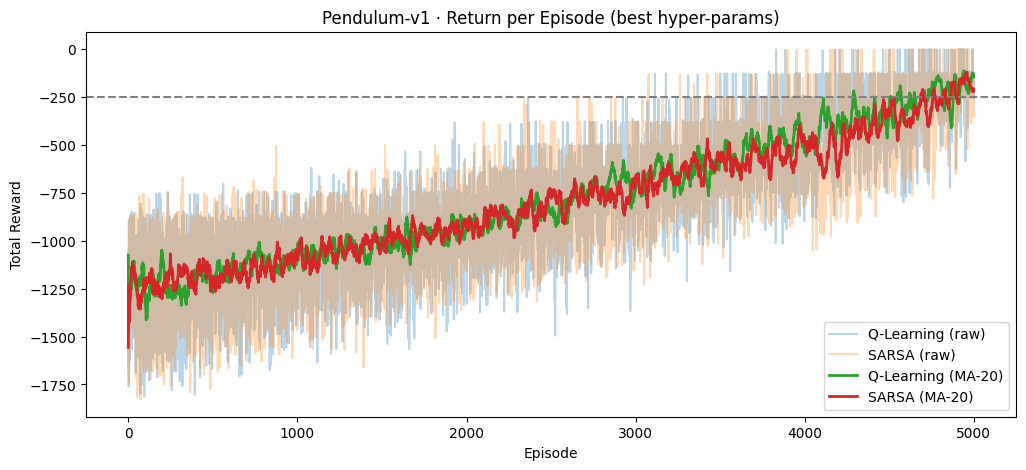

In [484]:
# 3. Consolidate and plot
Q_return_df.rename(columns={'Return':'Return_Q'}, inplace=True)
SARSA_return_df.rename(columns={'Return':'Return_SARSA'}, inplace=True)
df_eval = Q_return_df[['Episode','Return_Q']].merge(
            SARSA_return_df[['Episode','Return_SARSA']], on='Episode')

df_eval['MA_Q']     = df_eval['Return_Q'].rolling(20, min_periods=1).mean()
df_eval['MA_SARSA'] = df_eval['Return_SARSA'].rolling(20, min_periods=1).mean()

plt.figure(figsize=(12,5))
plt.plot(df_eval['Episode'], df_eval['Return_Q'],     alpha=.3, label='Q-Learning (raw)')
plt.plot(df_eval['Episode'], df_eval['Return_SARSA'], alpha=.3, label='SARSA (raw)')
plt.plot(df_eval['Episode'], df_eval['MA_Q'],         lw=2, label='Q-Learning (MA-20)')
plt.plot(df_eval['Episode'], df_eval['MA_SARSA'],     lw=2, label='SARSA (MA-20)')
plt.axhline(-250, ls='--', c='gray');               # reference
plt.title('Pendulum-v1 · Return per Episode (best hyper-params)')
plt.xlabel('Episode'); plt.ylabel('Total Reward'); plt.legend(); plt.show()


# One greedy run for each policy (render)

In [513]:
# 4. One greedy episode each
def run_greedy_episode(env, Q_table, title):
    state = env.reset()[0]; RETURN = 0; Done = False
    while not Done:
        ds = discretised_state(DISCRETE_BUCKETS, state)
        a_idx = int(np.argmax(Q_table[ds]))
        state, r, term, trunc, _ = env.step([float(DISCRETE_ACTIONS[a_idx])])
        Done = term or trunc; RETURN += r
    print(f"{title} · total reward: {RETURN:.1f}")

In [515]:
# Q-Learning
env_vis = gym.make('Pendulum-v1', render_mode='human')
run_greedy_episode(env_vis, Q_table_Q, 'Q-Learning (greedy)')
env_vis.close()

Q-Learning (greedy) · total reward: -246.3


In [519]:
# SARSA
env_vis = gym.make('Pendulum-v1', render_mode='human')
run_greedy_episode(env_vis, SARSA_Q_table, 'SARSA (greedy)')
env_vis.close()


SARSA (greedy) · total reward: -126.3


# Comparative metrics summary

In [522]:
# 5. Summary table
def summarise(df, col):
    return df[col].rolling(100).mean().max(), df[col].tail(100).mean()


In [524]:
best_q, fin_q  = summarise(df_eval, 'Return_Q')
best_s, fin_s  = summarise(df_eval, 'Return_SARSA')

summary = pd.DataFrame([
        ['Q-Learning', best_q, fin_q, best_alpha_q, best_gamma_q],
        ['SARSA',      best_s, fin_s, best_alpha_s, best_gamma_s]],
    columns=['Algorithm','Best 100-ep mean','Final 100-ep mean','α','γ'])
summary

,Algorithm,Best 100-ep mean,Final 100-ep mean,α,γ
0,Q-Learning,-170.391115,-170.391115,0.15,0.95
1,SARSA,-172.476328,-176.986032,0.15,0.90
